In [3]:
%reset -f
%clear

import torch
import os
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from utils.model_util import LeNet5, CNN
from utils.data_util import *
from utils.lib_util import *
from utils.train_util import *

# torch.backends.cudnn.enabled = True
# torch.backends.cudnn.benchmark = True
torch.set_printoptions(precision=2,
                       threshold=1000,
                       edgeitems=5,
                       linewidth=1000,
                       sci_mode=False)
# 是否使用显卡加速
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

# %% 原始数据处理
save_path = './data/dealed-data/'

dataset = 'mnist'
file_path = save_path + dataset + '_train_dataset_splited.pt'
if os.path.exists(file_path):
    [train_dataset_splited, test_dataset_o] = torch.load(file_path)
    print('file existed.')
else:
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    train_dataset_o, test_dataset_o = get_dataset(dataset)
    train_dataset_splited = split_data(train_dataset_o)
    torch.save([train_dataset_splited, test_dataset_o], file_path)

# %% 参数定义
alpha = 0.8
beta = 0.2

num_all_client = 6
num_all_server = 2
all_client = [i for i in range(num_all_client)]
all_server = [i for i in range(num_all_server)]
num_server_commu = 2
num_client_commu = 2
num_client_train = 2
num_public_train = 2

server_client_1 = [0, 1, 2]
server_client_2 = [3, 4, 5]
server_client = [server_client_1, server_client_2]
neighbor_server = [1, 0]



cuda
file existed.


In [5]:
# %% 训练集分配
idx_client_target = train_data_split(train_dataset_splited, all_client)
all_target = train_dataset_splited.keys()

public_idx, test_idx = split_idx_proportion(
    [i for i in range(len(test_dataset_o))], [0.2, 0.8])
public_dataset = [test_dataset_o[idx] for idx in public_idx]
test_dataset = [test_dataset_o[idx] for idx in test_idx]

train_dataset_client = get_list(num_all_client)
# train_dataset_client = []
# for i in range(num_all_client):
#     train_dataset_client.append([])
print(train_dataset_client)
for client in all_client:
    for target in all_target:
        train_dataset_client_new = [train_dataset_splited[target][idx]
                                    for idx in idx_client_target[client][target]]
        train_dataset_client[client].extend(train_dataset_client_new)

KeyboardInterrupt: 

In [3]:
initial_model = LeNet5(28, 28, 1, 10)

client_model = get_list(num_all_client, initial_model)
server_model = get_list(num_all_server)
server_accuracy = get_list(num_all_server)
client_accuracy = get_list(num_all_client)
server_client_model = get_list(num_all_server)
server_model_distillation_accuracy = get_list(num_all_server)

KeyboardInterrupt: 

In [12]:
for epoch_server_commu in range(num_server_commu):
    # 所有边缘服务器分别协调其客户端进行多轮联邦学习
    for epoch_client_commu in range(num_client_commu):
        # 所有边缘服务器分别协调其客户端进行联邦学习
        for server in all_server:
            # 每个服务器下单客户端分别训练
            for client in server_client[server]:
                # 单个服务器下的客户端在私有数据集上进行num_client_train轮训练
                print(epoch_server_commu, epoch_client_commu, server, client)
                client_model[client], loss_sum = train_model(
                    model=client_model[client],
                    dataset=train_dataset_client[client],
                    device=device,
                    epochs=num_client_train)
                # eval_model(client_model[client], test_dataset, device)
                # 单个服务器下的客户端在公开数据集上进行num_public_train轮训练
                if epoch_server_commu != 0:
                    neighbor_server_model = [
                        client_model[client] for client in server_model_distillation[neighbor_server[server]]]
                    weight = torch.tensor(
                        [1/len(neighbor_server_model) for _ in neighbor_server_model]).to(device)
                    client_model[client], loss_sum = train_model_disti(
                        model=client_model[client],
                        neighbor_server_model=neighbor_server_model,
                        weight=weight,
                        dataset=public_dataset,
                        device=device,
                        epochs=num_public_train,
                        num_target=len(all_target),
                        alpha=alpha,
                        beta=beta)
                # 在训练后评估该服务器下的客户端
                client_accuracy_client = eval_model(client_model[client], test_dataset, device)
                print(client_accuracy_client)
                print(type(client_accuracy))
                print(type(client_accuracy[client]))
                client_accuracy[client].append(client_accuracy_client.to('cpu'))
                # break
            break
        break
    break

0 0 0 0
<class 'torch.utils.data.dataloader.DataLoader'>
tensor(0.96, device='cuda:0')
<class 'list'>
<class 'list'>
0 0 0 1
<class 'torch.utils.data.dataloader.DataLoader'>


TypeError: len() of a 0-d tensor

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (119952, 2) + inhomogeneous part.

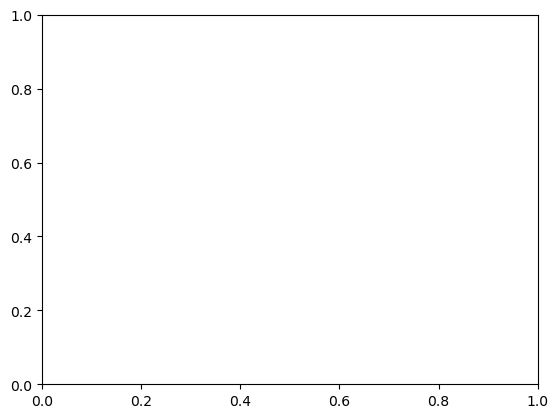

In [11]:
# %% 作图
x = range(epoch_client_commu)
line_list = []
for server in all_server:
    line_list.append(plt.plot(x, server_accuracy[server]))

plt.show()